In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

import btrdb
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds

import yaml

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    

In [3]:
#Establishing the connecting to the server
db = btrdb.connect(config['connection']['api_url'], apikey=config['connection']['api_key'])


In [11]:
currents = db.streams_in_collection('lndunn/PQdata/epri', tags={"unit": "amps"})
currents = [c for c in currents if c.name != 'In']
len(currents)

762

In [10]:
voltages = db.streams_in_collection('lndunn/PQdata/epri', tags={"unit": "volts"})
len(voltages)

762

In [14]:
start = voltages[0].earliest()[0].time
end = voltages[0].latest()[0].time
uuids = [s.uuid for s in voltages]

In [45]:
streamset = db.streams(*uuids[:25])
df = streamset.filter(start, end).to_dataframe()

In [72]:
df.head()

,lndunn/PQdata/epri/event3042/Va,lndunn/PQdata/epri/event3042/Vb,lndunn/PQdata/epri/event3042/Vc,lndunn/PQdata/epri/event3067/Va,lndunn/PQdata/epri/event3067/Vb,lndunn/PQdata/epri/event3067/Vc,lndunn/PQdata/epri/event3152/Va,lndunn/PQdata/epri/event3152/Vb,lndunn/PQdata/epri/event3152/Vc,lndunn/PQdata/epri/event3153/Va,...,lndunn/PQdata/epri/event3402/Va,lndunn/PQdata/epri/event3402/Vb,lndunn/PQdata/epri/event3402/Vc,lndunn/PQdata/epri/event3425/Va,lndunn/PQdata/epri/event3235/Va,lndunn/PQdata/epri/event3235/Vb,lndunn/PQdata/epri/event3235/Vc,lndunn/PQdata/epri/event3298/Va,lndunn/PQdata/epri/event3298/Vb,lndunn/PQdata/epri/event3298/Vc
time,,,,,,,,,,,,,,,,,,,,,
1104809946273000064,236.259308,-8430.299805,8749.614258,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1104809946273130240,733.647278,-8665.852539,8488.987305,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1104809946273260544,1206.165894,-8913.802734,8228.360352,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1104809946273390720,1641.380371,-9136.958008,7905.679688,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1104809946273521024,2089.029541,-9335.317383,7558.177246,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [62]:
# X = np.ones((len(df.keys()), len(df)))
X = df.to_numpy()

In [63]:
X.shape

(1148, 25)

In [69]:
from tslearn import clustering, utils

X_ts = utils.to_time_series_dataset(X.T)
km = clustering.TimeSeriesKMeans(n_clusters=1, max_iter=50, tol=1e-06, n_init=1, metric='dtw')
res = km.fit(X_ts)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [67]:
res.cluster_centers_.shape

(3, 3, 1)

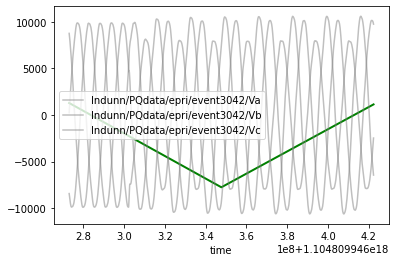

In [37]:
fig, ax = plt.subplots()
for ix in range(res.cluster_centers_.shape[0]):
    ax.plot(np.linspace(df.index.min(), df.index.max(), res.cluster_centers_.shape[1]), res.cluster_centers_[ix, :, 0], lw=2, color='g')
df.plot(ax=ax, color='0.5', alpha=0.5)
plt.show()

In [57]:
from tslearn.generators import random_walks
X = random_walks(n_ts=50, sz=32, d=1)
km = clustering.TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5,
                       random_state=0).fit(X)
print(km.cluster_centers_.shape)
km_dba = clustering.TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5,
                           max_iter_barycenter=5,
                           random_state=0).fit(X)
km_dba.cluster_centers_.shape

km_sdtw = clustering.TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=5,
                            max_iter_barycenter=5,
                            metric_params={"gamma": .5},
                            random_state=0).fit(X)
print(km_sdtw.cluster_centers_.shape)

X_bis = to_time_series_dataset([[1, 2, 3, 4],
                                 [1, 2, 3],
                                 [2, 5, 6, 7, 8, 9]])
km = clustering.TimeSeriesKMeans(n_clusters=2, max_iter=5,
                       metric="dtw", random_state=0).fit(X_bis)
print(km.cluster_centers_.shape)

(3, 32, 1)
(3, 32, 1)


NameError: name 'to_time_series_dataset' is not defined

In [59]:
X.shape

(50, 32, 1)

In [78]:
streaming = ['ni4ai','streaming','texas_pmus']

In [84]:
for coll in streaming:
    streams = db.streams_in_collection(coll)
    for _s in streams:
        if _s.name == 'FREQ':
            print(_s.collection, str(ns_to_datetime(_s.latest()[0].time)))

ni4ai/weld2 2021-01-09 19:05:27.466667+00:00
ni4ai/weld 2021-01-04 21:28:15.666667+00:00
streaming/zurich 2021-01-09 19:05:27.660000+00:00
texas_pmus/conroe 2021-01-09 19:05:27.900000+00:00
texas_pmus/whitesands 2021-01-09 19:05:28.033333+00:00
texas_pmus/centex 2021-01-09 19:05:28.100000+00:00


In [86]:
streams = db.streams_in_collection('lndunn')
streamdict = {}
for s in streams:
    path = s.collection.split('/')
    if path[1] not in streamdict.keys():
        streamdict[path[1]] = {}
    if path[2] not in streamdict[path[1]]:
        streamdict[path[1]][path[2]] = None

In [87]:
streamdict

{'events': {'switching_A': None, 'oscillations': None, 'switching_B': None},
 'brownout': {'whitesands': None, 'centex': None, 'conroe': None},
 'PQdata': {'underground': None, 'epri': None, 'site1': None},
 'sentinel': {'bedford': None}}